# Explainable emotion recognition

**Outline of the project :**
- Implement simple Facial Expression Recognition (FER) on FER2013 and AffectNet datasets
- Implement GradCAM
- Extend this to video (see ressources : In search of a robust facial expressions recognition model: A large-scale visual cross-corpus study) for datasets of dynamic emotion recognition

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

## Load the dataset

In [2]:
train_dir = "data/train" 
test_dir = "data/test" 
val_dir = "data/val" 

visu_transform = transforms.ToTensor()

visuset = datasets.ImageFolder(root=test_dir, transform=visu_transform)

class_to_idx = {"Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6}
idx_to_class = {v: k for k, v in class_to_idx.items()}

n_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

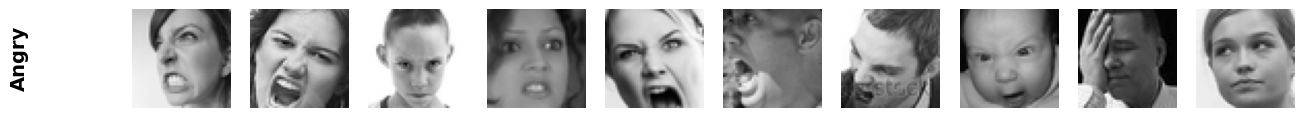

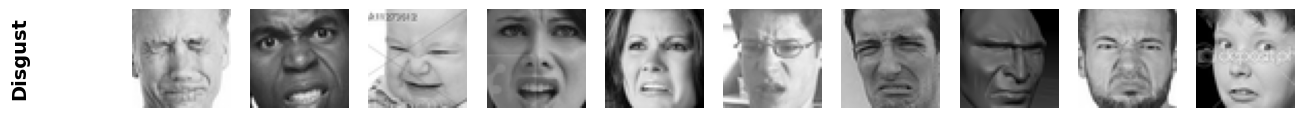

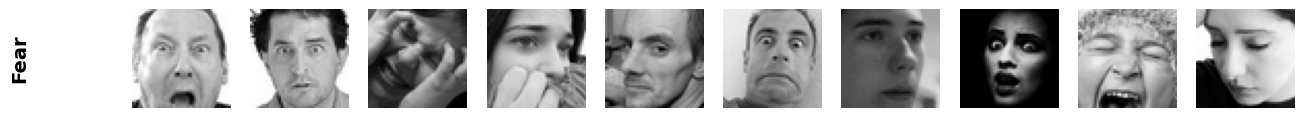

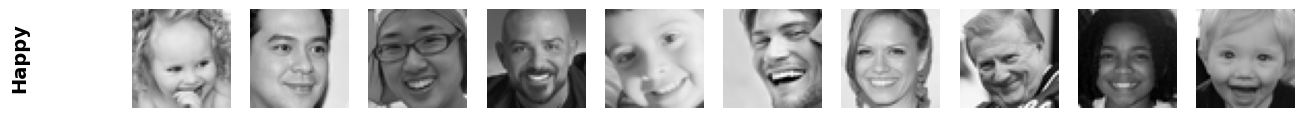

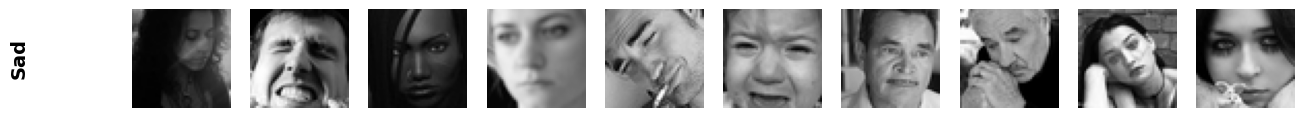

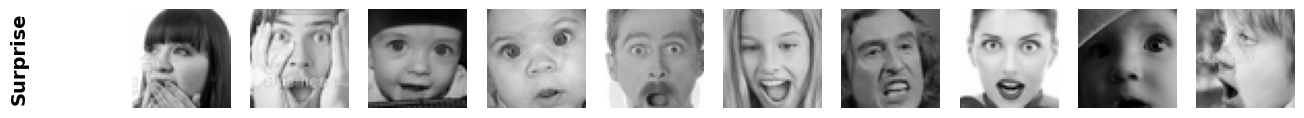

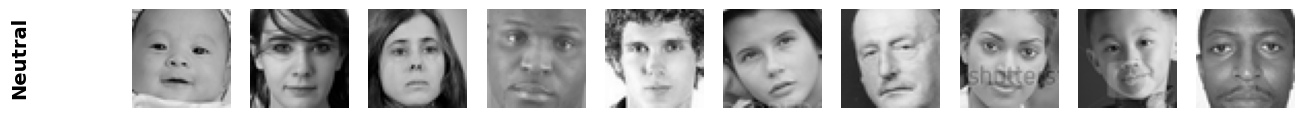

In [3]:
N = 10

visuloader = DataLoader(visuset, batch_size=None, shuffle=True)

# Find N examples per class
examples = {i: [] for i in range(n_classes)}
for img, label in visuloader:
    if len(examples[label]) < N:
        examples[label].append(img)
    if all(len(examples[i]) == N for i in range(n_classes)):
        break

# Plot examples
for i in range(n_classes):
    fig = plt.figure(figsize=(15, 2))
    for j in range(N):
        plt.subplot(1, N, j+1)
        plt.imshow(examples[i][j].permute(1, 2, 0))
        plt.axis("off")
    fig.text(0.05, 0.5, idx_to_class[i], va="center", ha="center", fontsize=14, fontweight="bold", rotation=90)

    plt.show()


## Finetune ResNet model

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

model.fc = nn.Linear(2048, n_classes)
print(model)

model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Training data

train_transform = transforms.Compose(
    [transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
    ]
    )
val_transform = transforms.Compose([
    # Instead of Resize + CenterCrop, just resize to 224×224 directly
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    
    # Convert the image to a tensor
    transforms.ToTensor(),
    
    # Normalize with ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
trainset = datasets.ImageFolder(root=train_dir, transform=train_transform)
valset = datasets.ImageFolder(root=val_dir, transform=val_transform)

In [6]:
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Training loop

def train(n_epochs, model, trainloader, valloader, optimizer, criterion):

    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(n_epochs):

        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))

        model.eval()
        val_loss, accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                val_loss += loss.item()
                accuracy += (outputs.argmax(dim=1) == labels.to(device)).float().mean().item()
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(accuracy / len(valloader))

        print(f">> Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.4f} - Validation accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Epoch 1/20 - Validation: 100%|██████████| 57/57 [00:09<00:00,  6.14it/s]


>> Training loss: 1.3337 - Validation loss: 1.3171 - Validation accuracy: 0.4853


Epoch 2/20 - Validation: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


>> Training loss: 1.1483 - Validation loss: 1.1072 - Validation accuracy: 0.5792


Epoch 3/20 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.78it/s]


>> Training loss: 1.0775 - Validation loss: 1.1105 - Validation accuracy: 0.5936


Epoch 4/20 - Validation: 100%|██████████| 57/57 [00:08<00:00,  6.36it/s]


>> Training loss: 1.0350 - Validation loss: 1.0895 - Validation accuracy: 0.5922


Epoch 5/20 - Validation: 100%|██████████| 57/57 [00:06<00:00,  8.49it/s]


>> Training loss: 0.9992 - Validation loss: 1.0111 - Validation accuracy: 0.6161


Epoch 6/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.14it/s]


>> Training loss: 0.9687 - Validation loss: 1.0151 - Validation accuracy: 0.6276


Epoch 7/20 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]


>> Training loss: 0.9470 - Validation loss: 0.9930 - Validation accuracy: 0.6360


Epoch 8/20 - Validation: 100%|██████████| 57/57 [00:08<00:00,  7.09it/s]


>> Training loss: 0.9177 - Validation loss: 0.9866 - Validation accuracy: 0.6404


Epoch 9/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.92it/s]


>> Training loss: 0.8989 - Validation loss: 0.9558 - Validation accuracy: 0.6532


Epoch 10/20 - Validation: 100%|██████████| 57/57 [00:08<00:00,  6.71it/s]


>> Training loss: 0.8757 - Validation loss: 0.9270 - Validation accuracy: 0.6569


Epoch 11/20 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.99it/s]


>> Training loss: 0.8505 - Validation loss: 0.9589 - Validation accuracy: 0.6538


Epoch 12/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.37it/s]


>> Training loss: 0.8341 - Validation loss: 0.9183 - Validation accuracy: 0.6686


Epoch 13/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.50it/s]


>> Training loss: 0.8111 - Validation loss: 0.9296 - Validation accuracy: 0.6648


Epoch 14/20 - Validation: 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


>> Training loss: 0.7936 - Validation loss: 0.9187 - Validation accuracy: 0.6609


Epoch 15/20 - Validation: 100%|██████████| 57/57 [00:08<00:00,  6.67it/s]


>> Training loss: 0.7689 - Validation loss: 0.9246 - Validation accuracy: 0.6654


Epoch 16/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  8.11it/s]


>> Training loss: 0.7495 - Validation loss: 0.9046 - Validation accuracy: 0.6678


Epoch 17/20 - Validation: 100%|██████████| 57/57 [00:09<00:00,  6.07it/s]


>> Training loss: 0.7342 - Validation loss: 0.9311 - Validation accuracy: 0.6645


Epoch 18/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.14it/s]


>> Training loss: 0.7081 - Validation loss: 0.9242 - Validation accuracy: 0.6706


Epoch 19/20 - Validation: 100%|██████████| 57/57 [00:06<00:00,  8.62it/s]


>> Training loss: 0.6947 - Validation loss: 0.9498 - Validation accuracy: 0.6610


Epoch 20/20 - Validation: 100%|██████████| 57/57 [00:07<00:00,  7.13it/s]

>> Training loss: 0.6746 - Validation loss: 0.9147 - Validation accuracy: 0.6763


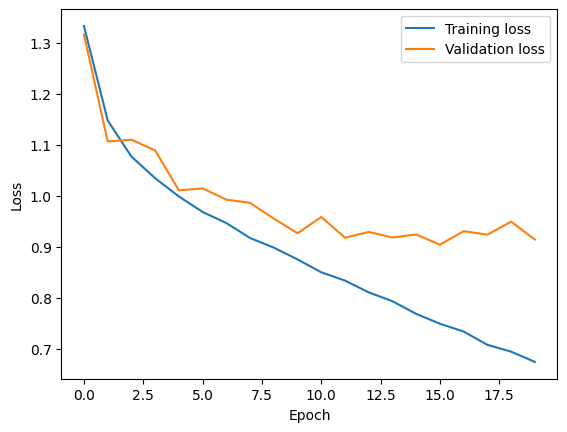

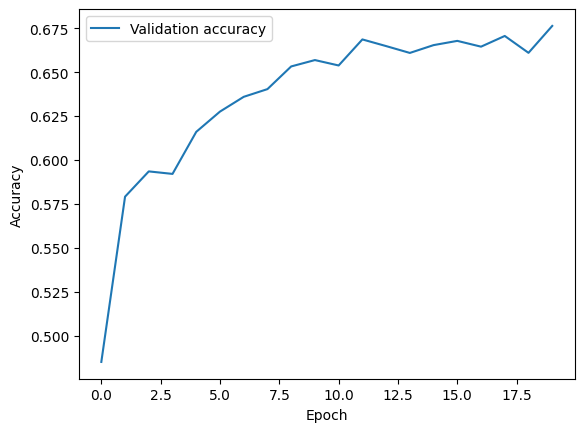

In [8]:
# Training

n_epochs = 20
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

train_losses, val_losses, val_accuracies = train(n_epochs, model, trainloader, valloader, optimizer, criterion)
plot_loss(train_losses, val_losses)
plot_accuracy(val_accuracies)

In [9]:
from torchcam.methods import SmoothGradCAMpp

model.eval()

# CAM initialisaiton
cam_layer = "layer4.1.conv2"
cam_extractor = SmoothGradCAMpp(model, target_layer=cam_layer)

# input - output
img, label = visuset[np.random.choice(len(visuset))]
output = model(preprocess(img).unsqueeze(0).to(device))

# CAM computation
activation_maps = cam_extractor(class_idx=output.squeeze(0).argmax().item(), scores=output)


In [10]:
# Overlayed on the image

from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

for name, map in zip(cam_extractor.target_names, activation_maps):
  result = overlay_mask(img, to_pil_image(map.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

TypeError: img and mask arguments need to be PIL.Image